### Costumer churn example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import tree

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [5]:
from sklearn.tree import DecisionTreeClassifier

In [6]:
telco_data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [7]:
telco_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
telco_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [9]:
telco_data.TotalCharges[telco_data.TotalCharges == " "]

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [10]:
telco_data = telco_data[telco_data.TotalCharges != " "]

In [11]:
telco_data.shape

(7032, 21)

In [12]:
telco_data[["TotalCharges"]] = telco_data[["TotalCharges"]].apply(pd.to_numeric)

In [13]:
telco_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [14]:
telco_data["SeniorCitizen"] = telco_data.SeniorCitizen.apply(lambda x: str(x))

In [15]:
# Extract list of categorical 
categorical_features = telco_data.columns[(telco_data.dtypes == "object")]
categorical_features = list(categorical_features[(categorical_features != "customerID") &
                  (categorical_features != "Churn")])

In [16]:
categorical_features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [17]:
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
target = "Churn"

In [18]:
churn_mask = telco_data.Churn == "Yes"

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12127d668>,
      dtype=object)

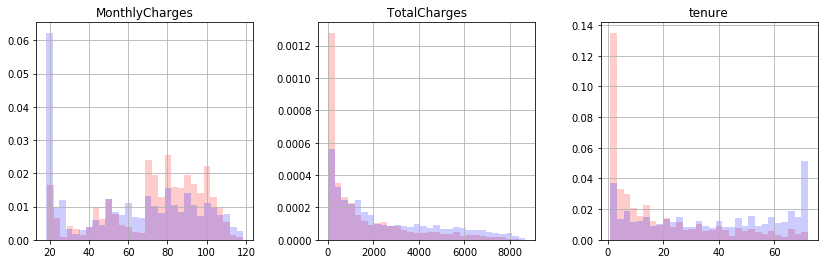

In [19]:
# Check disstribution of numerical features for churn vs no-churn costumers:

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
telco_data[numerical_features][churn_mask].hist(bins=30, color="red", alpha=0.2, ax=ax, density=True)
telco_data[numerical_features][~churn_mask].hist(bins=30, color="blue", alpha=0.2, ax=ax, density=True)

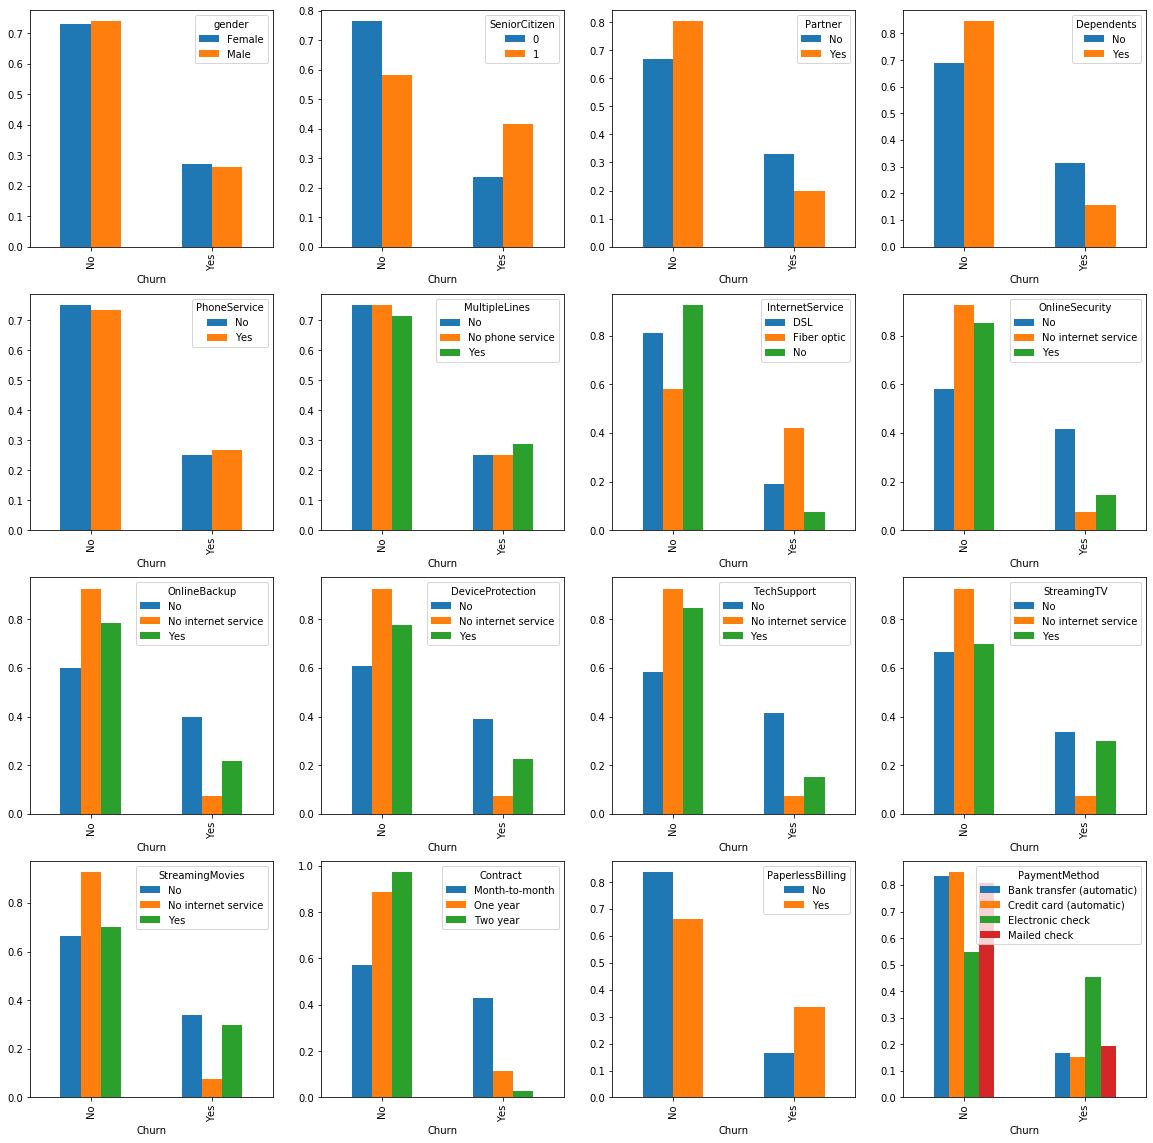

In [20]:
# Check distribution of categorical variables:

fig, ax = plt.subplots(4,4, figsize=(20,20))
ax = ax.ravel()
for n, feature in enumerate(categorical_features):
    pd.crosstab(index=telco_data["Churn"], columns=telco_data[feature]).apply(lambda r: r/r.sum(), axis=0).plot(ax=ax[n], kind="bar")

In [21]:
## Predictive model ML

In [22]:
## Encoding categorical features using OneHotEncoder:
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}

for categorical in categorical_features + [target]:
    label_encoders[categorical] = LabelEncoder()
    telco_data[categorical] = label_encoders[categorical].fit_transform(telco_data[categorical])
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder gender - values: ['Female', 'Male']
Label encoder SeniorCitizen - values: ['0', '1']
Label encoder Partner - values: ['No', 'Yes']
Label encoder Dependents - values: ['No', 'Yes']
Label encoder PhoneService - values: ['No', 'Yes']
Label encoder MultipleLines - values: ['No', 'No phone service', 'Yes']
Label encoder InternetService - values: ['DSL', 'Fiber optic', 'No']
Label encoder OnlineSecurity - values: ['No', 'No internet service', 'Yes']
Label encoder OnlineBackup - values: ['No', 'No internet service', 'Yes']
Label encoder DeviceProtection - values: ['No', 'No internet service', 'Yes']
Label encoder TechSupport - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingTV - values: ['No', 'No internet service', 'Yes']
Label encoder StreamingMovies - values: ['No', 'No internet service', 'Yes']
Label encoder Contract - values: ['Month-to-month', 'One year', 'Two year']
Label encoder PaperlessBilling - values: ['No', 'Yes']
Label encoder PaymentMethod - va

In [27]:
pipeline = Pipeline(
    [
        (
        "union",
        FeatureUnion(
            transformer_list=[
                (
                "categorical_features",
                Pipeline(
                [
                    ("selector", ItemSelector(key=categorical_features)),
                    ("onehot", OneHotEncoder()),
                ]
            ),
        )
        ]
         + [
             (
             "numerical_features",
             Pipeline(
             [
                 ("selector", ItemSelector(key=numerical_features)),
                 ("scalar", StandardScaler()),
             ]
        ),
        )
        ]
        ),
        ),
          ("classifier", DecisionTreeClassifier(max_depth=3, random_state=42))
    ]
)

In [28]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(telco_data, test_size=0.25, random_state=42)
pipeline.fit(df_train, df_train[target])
pred = pipeline.predict(df_test)

/Users/carlosjarguello/anaconda3/envs/python_36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
from sklearn.metrics import classification_report
print(classification_report(df_test[target], pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1300
           1       0.67      0.37      0.48       458

    accuracy                           0.79      1758
   macro avg       0.74      0.65      0.67      1758
weighted avg       0.77      0.79      0.77      1758



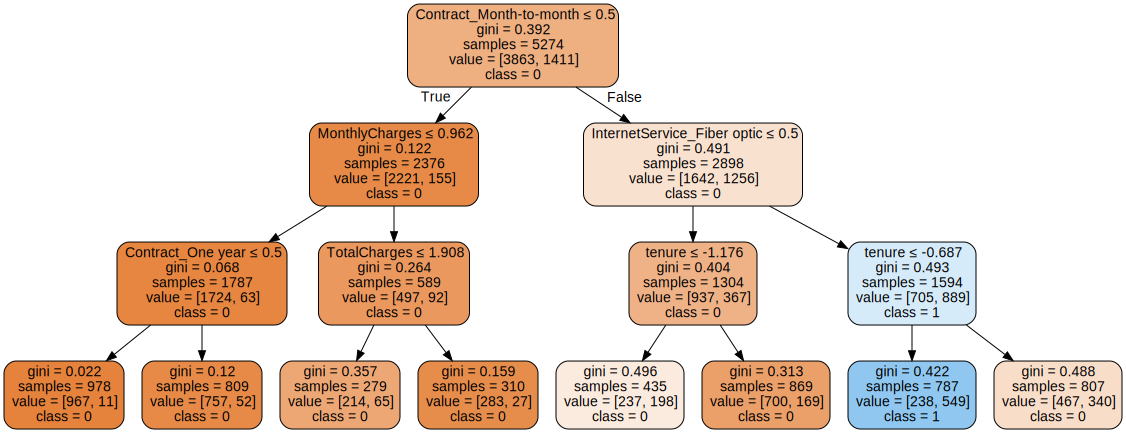

In [30]:
dot_data = tree.export_graphviz(pipeline.named_steps['classifier'], out_file=None, 
                         feature_names = categorical_feature_names + numerical_features,
                         class_names=[str(el) for el in pipeline.named_steps.classifier.classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

In [26]:
# from sklearn.linear_model import LogisticRegression 
# from sklearn.model_selection import train_test_split 
# from sklearn.metrics import confusion_matrix, accuracy_score 

# X_train, X_test, y_train, y_test = train_test_split(telco_data[x_select], data['Churn_Yes']) 
# clf = LogisticRegression(solver='lbfgs', max_iter=1000) clf.fit(X_train, y_train)

SyntaxError: invalid syntax (<ipython-input-26-b3589d886c20>, line 6)

In [44]:
## Cox proportional hazards model:

from lifelines import CoxPHFitter
cph = CoxPHFitter()

In [75]:
cph_train, cph_test, y_train, y_test  = train_test_split(telco_data[categorical_features+numerical_features], telco_data[target], test_size=0.2) 
cph_train["Churn"] = y_train

In [76]:
cph.fit(cph_train, "tenure", "Churn")

<lifelines.CoxPHFitter: fitted with 5625 total observations, 4128 right-censored observations>

In [77]:
cph.print_summary()

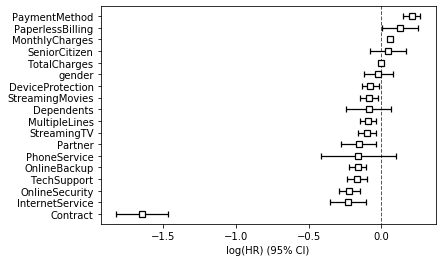

In [79]:
cph.plot()

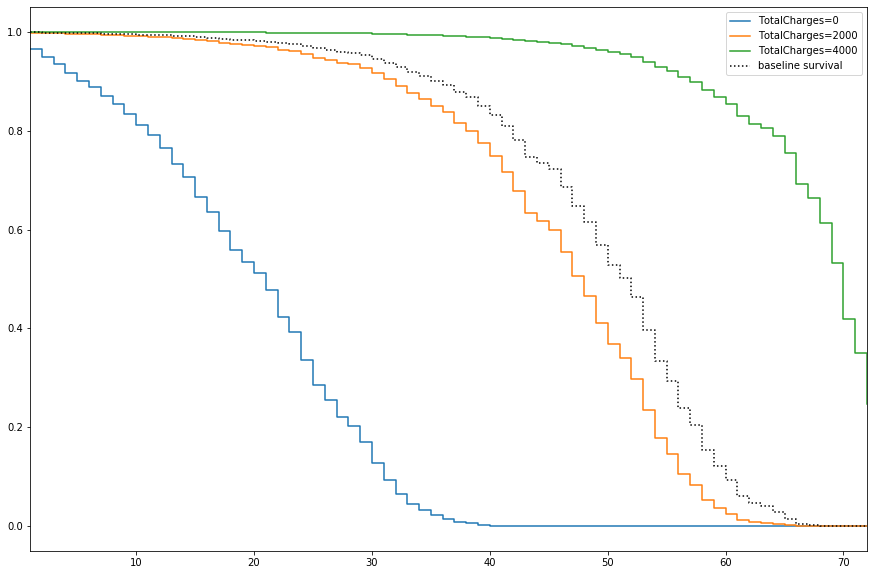

In [88]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
cph.plot_covariate_groups('TotalCharges', [0,2000, 4000], ax=ax)